In [1]:
import tensorflow as tf

In [2]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers, preprocessing, optimizers, Model

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
main_dir = "./dataset"
# classification_dirs = [("no_tumor",), ("meningioma_tumor",), ("glioma_tumor",), ("pituitary_tumor",) ]
classification_dirs = [("no_tumor",) ]

resolution = 64

def load_images(root_dir_name):
    x = []
    y = []
    
    for label, sub_dir_names in enumerate(classification_dirs):
        for sub_dir_name in sub_dir_names:
            print(f"loading {root_dir_name} {sub_dir_name}")
            sub_dir_path = os.path.join(main_dir, root_dir_name, sub_dir_name)
            for image_name in os.listdir(sub_dir_path):
                image_path = os.path.join(sub_dir_path, image_name)
                image = preprocessing.image.load_img(image_path, color_mode="grayscale", target_size=(resolution, resolution))
                x.append(preprocessing.image.img_to_array(image))
                y.append(label)
    
    x = np.array(x) / 255.0
    y = np.array(y)
    
    return x, y

x_train, y_train = load_images("Training")
x_test, y_test = load_images("Testing")

print("done loading!")
print("\nshapes:")
print(x_train.shape)
print(x_test.shape)

loading Training no_tumor
loading Testing no_tumor
done loading!

shapes:
(395, 64, 64, 1)
(105, 64, 64, 1)


In [45]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout

def make_model():
    # ENCODER
    input_img = layers.Input(shape=(64, 64, 1) )
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(input_img) # 64 x 64 x 
    x = Dropout(0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x) # 32 32 48
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x) #32 32 96
    x = Dropout(0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x) #16 16 96
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x) #16 16 192
    x = Dropout(0.5)(x)
    x = MaxPooling2D((2, 2), padding='same')(x) #8 8 192
    encoded = Conv2D(1024, (1, 1), activation='relu', padding='same')(x) #8 8 32
    x = Dropout(0.5)(x)

    # LATENT SPACE
    latentSize = (8,8,1024)

    # DECODER
    direct_input = Input(shape=latentSize)
    x = Conv2D(1024, (1, 1), activation='relu', padding='same')(direct_input)# 8 8 192
    x = Dropout(0.5)(x)
    x = UpSampling2D((2, 2))(x)# 16 16 192
    x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x) #16 16 192
    x = Dropout(0.5)(x)
    x = UpSampling2D((2, 2))(x) #32 32 192
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x) #32 32 96
    x = Dropout(0.5)(x)
    x = UpSampling2D((2, 2))(x) #64 64 96
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x) #64 64 48
    x = Dropout(0.5)(x)
    decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x) #64 64 1

    # COMPILE
    encoder = Model(input_img, encoded)
    decoder = Model(direct_input, decoded)
    autoencoder = Model(input_img, decoder(encoded))

    autoencoder.compile(optimizer='Adam', loss='mse')
    return autoencoder

In [46]:
model = make_model()

model.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 64, 64, 256)       2560      
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 256)       0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 32, 32, 512)       1180160   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 512)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 16, 16, 512)       0  

In [47]:
history = model.fit(x_train, x_train, batch_size=4, shuffle=True, epochs=50
                    , validation_data=(x_test, x_test))

Epoch 1/50
99/99 [==============================] - 20s 195ms/step - loss: 48.1308 - val_loss: 0.0819
Epoch 2/50
99/99 [==============================] - 20s 198ms/step - loss: 0.0250 - val_loss: 0.0544
Epoch 3/50
99/99 [==============================] - 20s 200ms/step - loss: 0.0227 - val_loss: 0.0519
Epoch 4/50
99/99 [==============================] - 20s 203ms/step - loss: 0.0219 - val_loss: 0.0568
Epoch 5/50
99/99 [==============================] - 19s 196ms/step - loss: 0.0213 - val_loss: 0.0539
Epoch 6/50
99/99 [==============================] - 20s 201ms/step - loss: 0.0203 - val_loss: 0.0498
Epoch 7/50
99/99 [==============================] - 20s 205ms/step - loss: 0.0201 - val_loss: 0.0468
Epoch 8/50
99/99 [==============================] - 20s 199ms/step - loss: 0.0199 - val_loss: 0.0506
Epoch 9/50
99/99 [==============================] - 20s 203ms/step - loss: 0.0206 - val_loss: 0.0403
Epoch 10/50
99/99 [==============================] - 20s 207ms/step - loss: 0.0194 - val_l

In [51]:
x_pred = model.predict(x_test)

In [52]:
x_pred[0].shape

(64, 64, 1)

In [53]:
import matplotlib.pyplot as plt

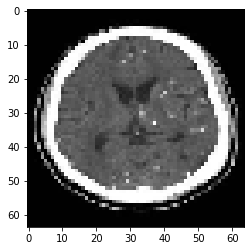

In [54]:
plt.imshow(x_test[1], cmap="gray")

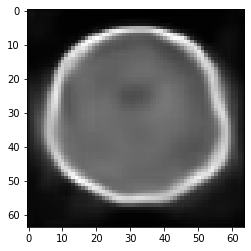

In [55]:
plt.imshow(x_pred[1], cmap="gray")